<a href="https://colab.research.google.com/github/WildArcher/CupIT2020/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Подготовка данных от Сергея

In [0]:
data = pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep=';')

In [0]:
data['time_start'] = pd.to_datetime(data['time_start'])
data['time_end'] = pd.to_datetime(data['time_end'])

In [0]:
data['duration'] = data['time_end'] - data['time_start']
data['min']= data['duration'].dt.seconds/60

In [0]:
data_target = data['min'].copy()

In [0]:
low, up = np.percentile(data['min'].values, [1 , 95]) 

bad_index = list(data[data['min'].values > up].index)

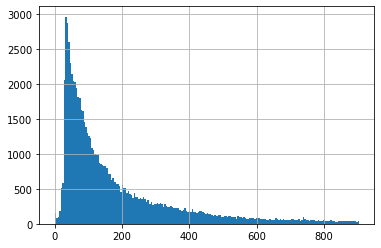

In [9]:
data['min'].drop(index=bad_index).hist(bins=200)

In [0]:
data.drop(index=bad_index, inplace=True)
data.index = range(data.shape[0])

## K-means



In [0]:
from sklearn.cluster import KMeans

new_data = data[['place_latitude', 'place_longitude']].copy()

In [152]:
%%time
kmeans = KMeans(n_clusters=900, random_state=42).fit(new_data)

CPU times: user 1min 45s, sys: 1min 10s, total: 2min 55s
Wall time: 1min 42s


In [0]:
new_data['class'] = kmeans.predict(new_data)

In [0]:
data['class'] = new_data['class']

In [0]:
data_for_time_series = data[['time_start', 'min']][data['class'] == 1].copy()

In [129]:
data_for_time_series

,time_start,min
343,2018-12-25 13:54:28,217.766667
344,2019-09-18 09:48:11,35.016667
345,2018-11-29 09:24:43,110.033333
346,2018-02-08 23:08:12,131.333333
398,2020-01-02 10:59:20,797.300000
...,...,...
74268,2019-04-05 09:14:03,34.433333
74269,2018-07-27 07:39:03,302.416667
74270,2018-04-19 07:18:00,463.066667
74277,2019-10-21 16:57:18,35.833333


## Time series для одного кластера


In [0]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression

In [0]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [132]:
data_for_time_series.index = data_for_time_series['time_start']
data_for_time_series["year"] = data_for_time_series.index.year
data_for_time_series["month"] = data_for_time_series.index.month
data_for_time_series["weekday"] = data_for_time_series.index.weekday
data_for_time_series["hour"] = data_for_time_series.index.hour
data_for_time_series["minute"] = data_for_time_series.index.minute
#data_for_time_series['is_weekend'] = data_for_time_series.weekday.isin([5,6])*1
data_for_time_series.drop(labels=['time_start'], inplace=True, axis=1)
data_for_time_series.head()

,min,year,month,weekday,hour,minute
time_start,,,,,,
2018-12-25 13:54:28,217.766667,2018,12,1,13,54
2019-09-18 09:48:11,35.016667,2019,9,2,9,48
2018-11-29 09:24:43,110.033333,2018,11,3,9,24
2018-02-08 23:08:12,131.333333,2018,2,3,23,8
2020-01-02 10:59:20,797.300000,2020,1,3,10,59


In [0]:
def prepareData(data, test_size):

    test_index = int(len(data)*(1-test_size))

    data.drop(['year', 'month', 'weekday', 'hour', 'minute'], axis=1, inplace=True)
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    data = data.sort_index()

    x_train = data.loc[:test_index]['min']
    x_test = data.loc[test_index:]['min']
    
    x_test = x_test.reset_index()

    return x_train, x_test

In [0]:
x_train, x_test = prepareData(data_for_time_series, test_size=0.3)

In [135]:
x_train

0       217.766667
1        35.016667
2       110.033333
3       131.333333
4       797.300000
           ...    
2413     35.183333
2414    749.516667
2415    483.483333
2416    294.883333
2417    170.333333
Name: min, Length: 2418, dtype: float64

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [0]:
window_size = 20
batch_size=32
test_size = 0.3
test_index = int(len(data_for_time_series)*(1-test_size))
def make_datasets(series, batch_size=32, window_size=20):
    shuffle_buffer_size = 1000
    train_dataset = tf.data.Dataset.from_tensor_slices(series)
    train_dataset = train_dataset.window(window_size + 1, shift=1, drop_remainder=True)
    train_dataset = train_dataset.flat_map(lambda window: window.batch(window_size + 1))
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    train_dataset = train_dataset.batch(batch_size).prefetch(1)
    return train_dataset

In [0]:
def mape(y_true, predicted):
    return np.mean(np.abs(y_true - np.ravel(predicted)) / y_true)

In [0]:
def make_prediction(model, data_for_time_series, window_size, test_index, x_test):
    
    forecast = []

    for time in range(len(data_for_time_series) - window_size):
        forecast.append(model.predict(data_for_time_series[time:time + window_size].T))


    forecast = forecast[test_index - window_size:]
    results = np.array(forecast)[:, 0]


    plt.figure(figsize=(10, 6))

    plt.plot(x_test, label='true')
    plt.plot(results, label='predicted')
    plt.title('MAPE: {}'.format(mape(x_test.values, results)))
    plt.legend()

# Пробуем RNN

In [0]:
from tensorflow.keras.layers import SimpleRNN, Lambda
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [0]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train, batch_size=128, window_size=30)
test_dataset = make_datasets(x_test, batch_size=128, window_size=30)

rnn = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                         SimpleRNN(32, return_sequences=True),
                         SimpleRNN(16),
                         Dense(8, activation='relu'),
                         Dense(1), 
                         Lambda(lambda x : x * 500.0)])

optimizer = tf.keras.optimizers.Adam()
rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

In [142]:
history = rnn.fit(train_dataset, epochs=50)

Epoch 1/50
19/19 [==============================] - 0s 20ms/step - loss: 95.9443
Epoch 2/50
19/19 [==============================] - 0s 22ms/step - loss: 79.3761
Epoch 3/50
19/19 [==============================] - 0s 20ms/step - loss: 79.1617
Epoch 4/50
19/19 [==============================] - 0s 21ms/step - loss: 79.9734
Epoch 5/50
19/19 [==============================] - 0s 22ms/step - loss: 77.8853
Epoch 6/50
19/19 [==============================] - 0s 21ms/step - loss: 79.0885
Epoch 7/50
19/19 [==============================] - 0s 21ms/step - loss: 78.1301
Epoch 8/50
19/19 [==============================] - 0s 19ms/step - loss: 76.9513
Epoch 9/50
19/19 [==============================] - 0s 20ms/step - loss: 76.9362
Epoch 10/50
19/19 [==============================] - 0s 21ms/step - loss: 76.9627
Epoch 11/50
19/19 [==============================] - 0s 20ms/step - loss: 73.9562
Epoch 12/50
19/19 [==============================] - 0s 19ms/step - loss: 72.4698
Epoch 13/50
19/19 [======

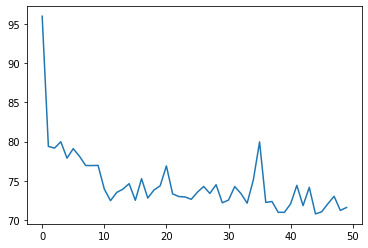

In [143]:
plt.plot(history.history['loss'])

# После многочисленых испытаний - лучшая модель == rnn

In [0]:
data_for_time_series = data_for_time_series.sort_index()

In [145]:
data_for_time_series.head()

,min
time_start,
2018-01-01 09:57:24,19.083333
2018-01-02 04:32:33,28.916667
2018-01-04 03:29:47,89.733333
2018-01-08 13:36:51,35.633333
2018-01-08 18:39:07,284.600000


In [0]:
test_size = 0.1
test_index = int(len(data_for_time_series) * (1-test_size))

data_for_time_series = data_for_time_series.reset_index(drop=True)

x_train = data_for_time_series.loc[:test_index]['min']
x_test = data_for_time_series.loc[test_index:]['min']
    
x_test = x_test.reset_index()

x_test = x_test.drop(columns=['index'])

In [0]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train, batch_size=200, window_size=40)
test_dataset = make_datasets(x_test, batch_size=200, window_size=40)

rnn = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                         SimpleRNN(32, return_sequences=True),
                         SimpleRNN(16),
                         Dense(8, activation='relu'),
                         Dense(1), 
                         Lambda(lambda x : x * 500.0)])

optimizer = tf.keras.optimizers.Adam()
rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

In [148]:
history = rnn.fit(train_dataset, epochs=50)

Epoch 1/50
16/16 [==============================] - 1s 37ms/step - loss: 269.7163
Epoch 2/50
16/16 [==============================] - 1s 33ms/step - loss: 104.8454
Epoch 3/50
16/16 [==============================] - 1s 31ms/step - loss: 81.8586
Epoch 4/50
16/16 [==============================] - 1s 31ms/step - loss: 76.4217
Epoch 5/50
16/16 [==============================] - 0s 30ms/step - loss: 74.3281
Epoch 6/50
16/16 [==============================] - 1s 34ms/step - loss: 71.9410
Epoch 7/50
16/16 [==============================] - 1s 38ms/step - loss: 73.5026
Epoch 8/50
16/16 [==============================] - 1s 34ms/step - loss: 71.3170
Epoch 9/50
16/16 [==============================] - 1s 33ms/step - loss: 75.0932
Epoch 10/50
16/16 [==============================] - 1s 33ms/step - loss: 72.1897
Epoch 11/50
16/16 [==============================] - 0s 31ms/step - loss: 72.3142
Epoch 12/50
16/16 [==============================] - 0s 31ms/step - loss: 76.0340
Epoch 13/50
16/16 [====

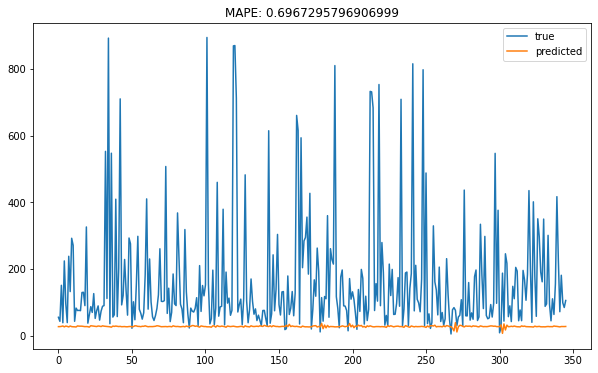

In [149]:
make_prediction(rnn, data_for_time_series, 40, test_index, x_test)

# Модель довольно странно подогналась под MAPE, но зато это лучшее, что получилось. Что важно, она довольно устойчива и не склонна к переобучению. Главный недостаток - отсутсвие смелых прогнозов, но это позволяет выдовать приемлемый MAPE.

## RNN для всех данных

In [150]:
mape = np.zeros(len(np.unique(data['class'])))

for i in range(3):

  data_for_time_series = data[['time_start', 'min']][data['class'] == i].copy()

  data_for_time_series.index = data_for_time_series['time_start']
  data_for_time_series["year"] = data_for_time_series.index.year
  data_for_time_series["month"] = data_for_time_series.index.month
  data_for_time_series["weekday"] = data_for_time_series.index.weekday
  data_for_time_series["hour"] = data_for_time_series.index.hour
  data_for_time_series["minute"] = data_for_time_series.index.minute
  #data_for_time_series['is_weekend'] = data_for_time_series.weekday.isin([5,6])*1
  data_for_time_series.drop(labels=['time_start'], inplace=True, axis=1)

  data_for_time_series = data_for_time_series.sort_index()

  x_train, x_test = prepareData(data_for_time_series, test_size=0.3)

  test_size = 0.1
  test_index = int(len(data_for_time_series) * (1-test_size))

  data_for_time_series = data_for_time_series.reset_index(drop=True)

  x_train = data_for_time_series.loc[:test_index]['min']
  x_test = data_for_time_series.loc[test_index:]['min']
    
  x_test = x_test.reset_index()

  x_test = x_test.drop(columns=['index'])

  tf.keras.backend.clear_session()

  train_dataset = make_datasets(x_train, batch_size=200, window_size=40)
  test_dataset = make_datasets(x_test, batch_size=200, window_size=40)

  optimizer = tf.keras.optimizers.Adam()
  rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

  history = rnn.fit(train_dataset, epochs=50)

  make_prediction(rnn, data_for_time_series, 40, test_index, x_test)


Epoch 1/50
27/27 [==============================] - 1s 39ms/step - loss: 78.7482
Epoch 2/50
27/27 [==============================] - 1s 39ms/step - loss: 85.5528
Epoch 3/50
27/27 [==============================] - 1s 38ms/step - loss: 82.3744
Epoch 4/50
27/27 [==============================] - 1s 39ms/step - loss: 76.5087
Epoch 5/50
27/27 [==============================] - 1s 40ms/step - loss: 82.0074
Epoch 6/50
27/27 [==============================] - 1s 37ms/step - loss: 74.8472
Epoch 7/50
27/27 [==============================] - 1s 38ms/step - loss: 75.7642
Epoch 8/50
27/27 [==============================] - 1s 40ms/step - loss: 80.7805
Epoch 9/50
27/27 [==============================] - 1s 36ms/step - loss: 80.4430
Epoch 10/50
27/27 [==============================] - 1s 35ms/step - loss: 75.7299
Epoch 11/50
27/27 [==============================] - 1s 36ms/step - loss: 76.2143
Epoch 12/50
27/27 [==============================] - 1s 39ms/step - loss: 75.1350
Epoch 13/50
27/27 [======

KeyboardInterrupt: ignored